✅ Data Loaded Successfully.
      video_id trending_date  \
0  2kyS6SvSYSE      17.14.11   
1  1ZAPwfrtAFY      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  puqaWrEC7tY      17.14.11   
4  d380meD0W0M      17.14.11   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   

   category_id               publish_time  \
0           22  2017-11-13 17:13:01+00:00   
1           24  2017-11-13 07:30:00+00:00   
2           23  2017-11-12 19:05:24+00:00   
3           24  2017-11-13 11:00:04+00:00   
4           24  2017-11-12 18:01:41+00:00   

                                 

a:\Youtube-TrendAnalysis-2\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:33:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 XGBoost Classifier Report
              precision    recall  f1-score   support

           0       0.66      0.71      0.69      4091
           1       0.69      0.64      0.66      4090

    accuracy                           0.67      8181
   macro avg       0.68      0.67      0.67      8181
weighted avg       0.68      0.67      0.67      8181

ROC-AUC Score: 0.7443923359703661


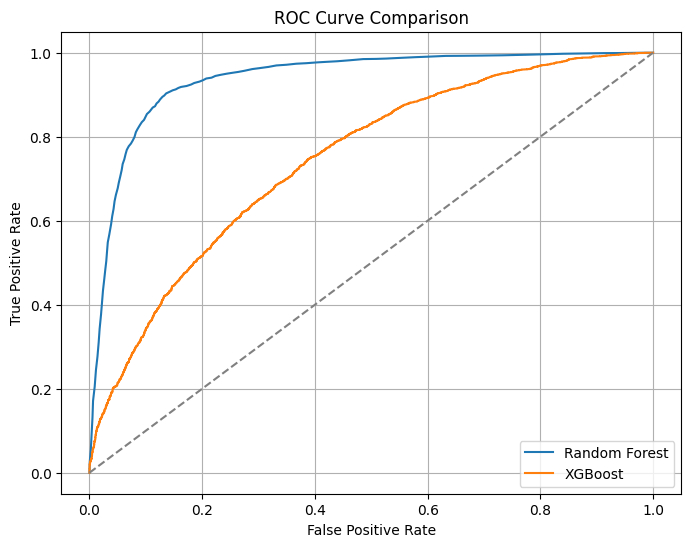


✅ XGBoost model saved at '../models/recommendation_model.pkl' successfully.

📈 Best Hours to Upload for Trending Probability:
hour
9     0.757812
4     0.697959
12    0.673981
21    0.646789
19    0.535469
13    0.532637
6     0.532110
22    0.522613
18    0.508772
20    0.476804
1     0.454545
14    0.451724
5     0.415584
17    0.414030
15    0.410364
0     0.400000
16    0.392758
2     0.370787
3     0.364583
7     0.353846
23    0.345890
11    0.329949
10    0.326316
8     0.154321
Name: predicted, dtype: float64


C:\Users\hiite\AppData\Local\Temp\ipykernel_18744\1698914932.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=best_hours.index, y=best_hours.values, palette="viridis")


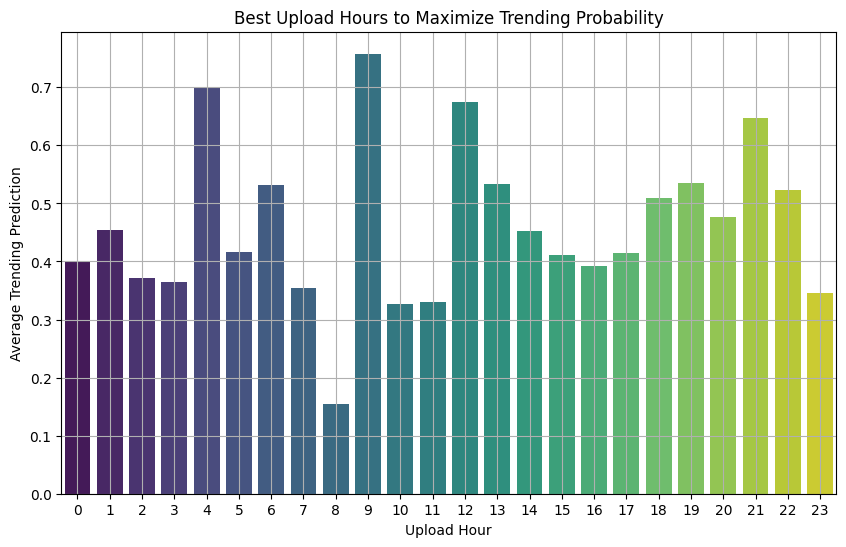


✅ Sample predict_proba output: [[0.5563959  0.44360408]]


In [1]:
# 1. Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# 2. Load Data
data = pd.read_csv('../data/processed_data.csv')  # Adjust path if needed
print("✅ Data Loaded Successfully.")
print(data.head())

# 3. Feature Engineering
data['title_length'] = data['title'].apply(lambda x: len(str(x)))
data['num_tags'] = data['tags'].apply(lambda x: len(str(x).split('|')) if pd.notnull(x) else 0)
data['upload_hour'] = pd.to_datetime(data['publish_time']).dt.hour

# New Feature - Video Length
# If you have real video length, use it here. Otherwise simulate.
if 'video_length' not in data.columns:
    np.random.seed(42)
    data['video_length'] = np.random.uniform(1, 20, size=len(data))  # Random minutes

print("✅ Features Created: title_length, num_tags, upload_hour, video_length")

# 4. Create Target Variable
if 'is_trending' not in data.columns:
    threshold = data['views'].median()
    data['is_trending'] = data['views'].apply(lambda x: 1 if x > threshold else 0)
    print("✅ Created 'is_trending' column based on views median threshold.")

# 5. Define Features and Target
features = ['title_length', 'num_tags', 'upload_hour', 'video_length']  # Updated feature order
X = data[features]
y = data['is_trending']

# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("\n🎯 Checking y_train distribution:")
print(y_train.value_counts())

# 7. Baseline Model - Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Predictions
rf_preds = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("\n📊 Random Forest Classifier Report")
print(classification_report(y_test, rf_preds))
print("ROC-AUC Score:", roc_auc_score(y_test, rf_probs))

# 8. Advanced Model - XGBoost (Safe Training)
if len(y_train.unique()) >= 2:
    print("✅ Enough classes. Training XGBoost...")

    xgb_model = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train, y_train)

    # Predictions
    xgb_preds = xgb_model.predict(X_test)
    xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

    # Evaluation
    print("\n📊 XGBoost Classifier Report")
    print(classification_report(y_test, xgb_preds))
    print("ROC-AUC Score:", roc_auc_score(y_test, xgb_probs))

else:
    print("❌ XGBoost not trained. Only one class in y_train.")

# 9. Plot ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest')

# Plot XGBoost ROC curve if trained
if 'xgb_probs' in locals():
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
    plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')

plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()

# 10. Save the Best Model (ONLY to /models/)
os.makedirs('../models', exist_ok=True)  # Make sure models folder exists

if 'xgb_model' in locals():
    with open('../models/recommendation_model.pkl', 'wb') as f:
        pickle.dump(xgb_model, f)
    print("\n✅ XGBoost model saved at '../models/recommendation_model.pkl' successfully.")
else:
    with open('../models/recommendation_model.pkl', 'wb') as f:
        pickle.dump(rf_model, f)
    print("\n✅ Random Forest model saved at '../models/recommendation_model.pkl' successfully.")

# 11. Optimization Suggestions (Best Upload Hour)
upload_hour_performance = pd.DataFrame({
    'hour': X_test['upload_hour'],
    'actual': y_test,
    'predicted': rf_preds if 'xgb_preds' not in locals() else xgb_preds
})
best_hours = upload_hour_performance.groupby('hour')['predicted'].mean().sort_values(ascending=False)

print("\n📈 Best Hours to Upload for Trending Probability:")
print(best_hours)

# Visualize
plt.figure(figsize=(10,6))
sns.barplot(x=best_hours.index, y=best_hours.values, palette="viridis")
plt.title('Best Upload Hours to Maximize Trending Probability')
plt.xlabel('Upload Hour')
plt.ylabel('Average Trending Prediction')
plt.xticks(range(0,24))
plt.grid()
plt.show()

# 12. (Important) Test predict_proba with new input
sample_input = pd.DataFrame({
    'title_length': [60],
    'num_tags': [10],
    'upload_hour': [17],
    'video_length': [12.5]   # Example 12.5 minutes
})

# Load model for testing
with open('../models/recommendation_model.pkl', 'rb') as f:
    model = pickle.load(f)

sample_probs = model.predict_proba(sample_input)
print("\n✅ Sample predict_proba output:", sample_probs)
